<div class="alert alert-block alert-info">
Case: big online store, marketing department.
1st task: evaluate 9 hypotheses using ICE and RICE approaches.  

#### Description of the data

- `Hypotheses` — brief descriptions of the hypotheses
- `Reach` — user reach, on a scale of one to ten
- `Impact` — impact on users, on a scale of one to ten
- `Confidence` — confidence in the hypothesis, on a scale of one to ten
- `Effort` — the resources required to test a hypothesis, on a scale of one to ten. The higher the `Effort` value, the more resource-intensive the test.

**Data for AAB-test

- `transactionId` — order identifier
- `visitorId` — identifier of the user who placed the order
- `date` — of the order
- `revenue` — from the order
- `group` — the A/B test group that the user belongs to
- `date` — date
- `group` — A/B test group
- `~~visitors` — the number of visitors on the date specified in the A/B test group specified~~
- `visits` — the number of visits on the date specified for the A/B test group specified

Make sure to preprocess the data. There might be mistakes in the original datasets; for example, some of the visitors might have gotten into both group A and group B.

I. [Data preprocessing](#preproc) - we need the data to be brought to the required types and uniformity, otherwise it is difficult to filter.


II. [Hypothesis prioritization](#hyps) on the Ice Rice methods to help managers decide which product hypothesis will hit the team the least but will (probably) bring the most value to the business.

III. [Visualize data](#plots), pay attention to anomalies. Our task also includes this: to prevent hasty decisions from being made on the basis of superficial data analysis. This is what happens when you just look at charts. Catching mind traps.

IV. Find [outliers](#outliers) that affect the result and interpretation of the graphs.

V. We analyze [ab-test](#statsign), the threshold of statistical significance is 0.05. We look at whether we reject the null hypothesis (that groups A and B are equal) or whether there is reason to believe that there is a tangible difference. We clean the data and check what has changed.

VII. We give our vision in [Results of the work] (#concl). We are trying to convince the "decision makers".


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from pandas.plotting import register_matplotlib_converters
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

In [2]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')
hyp = pd.read_csv('/datasets/hypothesis.csv')

## Data Preprocessing
Any intersections? Duplicates?
<a class="anchor" id="preproc">

In [3]:
display(orders.head(3))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


In [4]:
visitors.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [5]:
#Checking if there are any in both groups (set())
compare=[]
dfs = {'Заказы': orders, 
       'Посещения':visitors,
      'Гипотезы': hyp}
for x, y in dfs.items():
    compare1=set(x).intersection(y)
    print(compare1)

set()
set()
set()


In [6]:
print(visitors.duplicated(keep=False))
visitors.isna()

0     False
1     False
2     False
3     False
4     False
      ...  
57    False
58    False
59    False
60    False
61    False
Length: 62, dtype: bool


,date,group,visitors
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
57,False,False,False
58,False,False,False
59,False,False,False
60,False,False,False


In [7]:
perc_orders =[.20, .40, .95, .99]
orders.describe(percentiles=perc_orders)

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
20%,8.850109e+08,8.878313e+08,9.900000e+02
40%,1.734876e+09,1.763973e+09,2.210000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
95%,4.067471e+09,4.080749e+09,2.800000e+04
99%,4.239148e+09,4.256040e+09,5.823320e+04
max,4.293856e+09,4.283872e+09,1.294500e+06


In [ ]:
# Percentiles overview

In [8]:
perc_orders =[.20, .40, .95, .99]
orders['revenue'].describe(percentiles=perc_orders) 

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
20%      9.900000e+02
40%      2.210000e+03
50%      2.978000e+03
95%      2.800000e+04
99%      5.823320e+04
max      1.294500e+06
Name: revenue, dtype: float64

In [9]:
print(orders.duplicated(keep=False))
orders.isna()

0       False
1       False
2       False
3       False
4       False
        ...  
1192    False
1193    False
1194    False
1195    False
1196    False
Length: 1197, dtype: bool


,transactionId,visitorId,date,revenue,group
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
1192,False,False,False,False,False
1193,False,False,False,False,False
1194,False,False,False,False,False
1195,False,False,False,False,False


In [10]:
#for_intersection = pd.DataFrame(orders.groupby('date')['visitorId'].agg('count'))
#visitors.head()

In [11]:
#visitors.describe()

## Hypothesis prioritization
Can we improve anything on landing?

<a class="anchor" id="hyps">

In [12]:
# Hypothesis received

In [13]:
hyp['ICE'] = (hyp['Impact'] * hyp['Confidence']) / hyp['Efforts']
with pd.option_context('display.max_colwidth', 0):
    print(hyp[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending = False)['Hypothesis'].head(3).tolist())

['Запустить акцию, дающую скидку на товар в день рождения', 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей', 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок']


Translation: 'Launch a birthday discount promotion', 'Add two new traffic acquisition channels to generate 30% more users', 'Add a subscription form to all main pages to build a customer base for email newsletters'

<a id = 'ice'>

### Preliminary conclusions ICE

Applying the ICE method, we can conclude that according to the Impact of the hypothesis:
- 'Start a birthday discount promotion',
- 'Add two new channels to attract traffic, which will attract 30% more users',
- 'Add a subscription form to all main pages to build a customer base for email newsletters'.

### RICE method

In [14]:
hyp['RICE'] = (hyp['Reach'] * hyp['Impact'] * hyp['Confidence']) / hyp['Efforts']
with pd.option_context('display.max_colwidth', 0):
    print(hyp[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending = False)['Hypothesis'].head(3).tolist())


['Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок', 'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа', 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей']


Translation: 'Add a subscription form to all main pages to collect a customer base for email newsletters', 'Add product recommendation blocks to the online store website to increase conversion and average check of the order', 'Add two new traffic acquisition channels, which will attract 30% more users'

In [15]:
hyp.sort_values('ICE')

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2


In [16]:
hyp.sort_values('RICE')

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0


### Preliminary results on RICE
Applying the RICE method, we can conclude that the priority hypotheses will be:
- 'Add a subscription form to all main pages to build a customer base for email newsletters',
- 'Add product recommendation blocks to the website of the online store to increase the conversion and the average check of the order',
- 'Add two new channels to attract traffic, which will attract 30% more users'

## Анализ A/B-теста



### Preprocessing (dates, outliers detection)

In [17]:
# даты проведения АВ теста по 
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [18]:
# Outlier found and eliminated
orders = orders[orders['revenue']<1294500]

## Difference between groups
<a class="anchor" id="compare">
    
This information can be conveyed to managers. I proceeded from the fact that these parameters were taken into account during the ab-test. Because before the start of the ab-test <a href='https://radar-research.ru/software/z-test_calculator/'>it was possible to use an available calculator</a>. Usually, at least this is done before the start of the ab-test, this is a necessary formality.

It happens that the disproportion in the samples can distort the interpretation of the data. The so-called Type I error. <a href='https://en.wikipedia.org/wiki/Type_I_and_type_II_errors'>Read here</a>.




In [19]:
visAcount = visitors[visitors['group']=='A']['visitors'].sum().astype(int)
visBcount = visitors[visitors['group']=='B']['visitors'].sum().astype(int)
print(visAcount, ',',  visBcount)

18736 , 18916


The number of visitors in group A and group B is almost the same, but we need to check with statistics. I will go the easy way: <a href='https://radar-research.ru/software/z-test_calculator/'> looked here</a>. Below is the search for clients who have flown into both groups, and making a decision whether to remove them or not.

In [20]:
intersections = pd.DataFrame(orders.groupby('visitorId')['group'].agg('unique'))

In [21]:
intersectionAB = intersections[intersections.group.map(len)>1]
print(intersectionAB)
print(intersectionAB.count())

len(intersectionAB)/len(orders)

             group
visitorId         
8300375     [B, A]
199603092   [A, B]
232979603   [B, A]
237748145   [B, A]
276558944   [B, A]
351125977   [B, A]
393266494   [A, B]
457167155   [B, A]
471551937   [A, B]
477780734   [A, B]
818047933   [A, B]
963407295   [B, A]
1230306981  [A, B]
1294878855  [B, A]
1316129916  [A, B]
1333886533  [A, B]
1404934699  [B, A]
1602967004  [B, A]
1614305549  [B, A]
1648269707  [B, A]
1668030113  [B, A]
1738359350  [A, B]
1801183820  [B, A]
1959144690  [A, B]
2038680547  [B, A]
2044997962  [A, B]
2378935119  [A, B]
2458001652  [A, B]
2579882178  [A, B]
2587333274  [B, A]
2600415354  [B, A]
2654030115  [B, A]
2686716486  [A, B]
2712142231  [B, A]
2716752286  [B, A]
2780786433  [A, B]
2927087541  [A, B]
2949041841  [A, B]
2954449915  [A, B]
3062433592  [B, A]
3202540741  [A, B]
3234906277  [B, A]
3656415546  [A, B]
3717692402  [B, A]
3766097110  [A, B]
3803269165  [A, B]
3891541246  [A, B]
3941795274  [A, B]
3951559397  [B, A]
3957174400  [A, B]
3963646447  

0.048494983277591976


The share of those who flew into A and B is less than 5%, I think, let them stay.

→ Another approach: `set — list(set(orders.query('group =="A"')['visitorId']) & set(orders.query('group =="B"')['visitorId']))`

→ Yet another approach: `.agg('nunique') and immediately get the number of items each user has. And then just choose those who have two groups. - orders.groupby('visitorId')['group'].agg('nunique').reset_index().query('group > 1')`

In [22]:
# формат даты в посещениях
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [23]:
#Calculating max order date 
dates = pd.DataFrame({"date": pd.date_range(orders['date'].min(), orders["date"].max())}) #новая строка

In [24]:
# ABtest dates
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.describe()

,date,group
count,62,62
unique,31,2
top,2019-08-02 00:00:00,A
freq,2,31
first,2019-08-01 00:00:00,NaN
last,2019-08-31 00:00:00,NaN


In [25]:
# Cumulative data for each group 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), 
                                     axis=1).sort_values(by=['date','group'])

# Cumulative data for each group (visits)
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                         visitors['group'] == x['group'])]\
.agg({'date' : 'max','group' : 'max', 'visitors' : 'sum'}), 
                                       axis=1).sort_values(by=['date','group'])

# Cumulative data for each group (visits and orders)
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cummulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


## Ploting
<a class="anchor" id="plots">

In [26]:
#А: orders and revenue
cummulativeRevenueA = cummulativeData[cummulativeData['group']=='A'][['date','revenue', 'orders']]

#В: orders and revenue
cummulativeRevenueB = cummulativeData[cummulativeData['group']=='B'][['date','revenue', 'orders']]

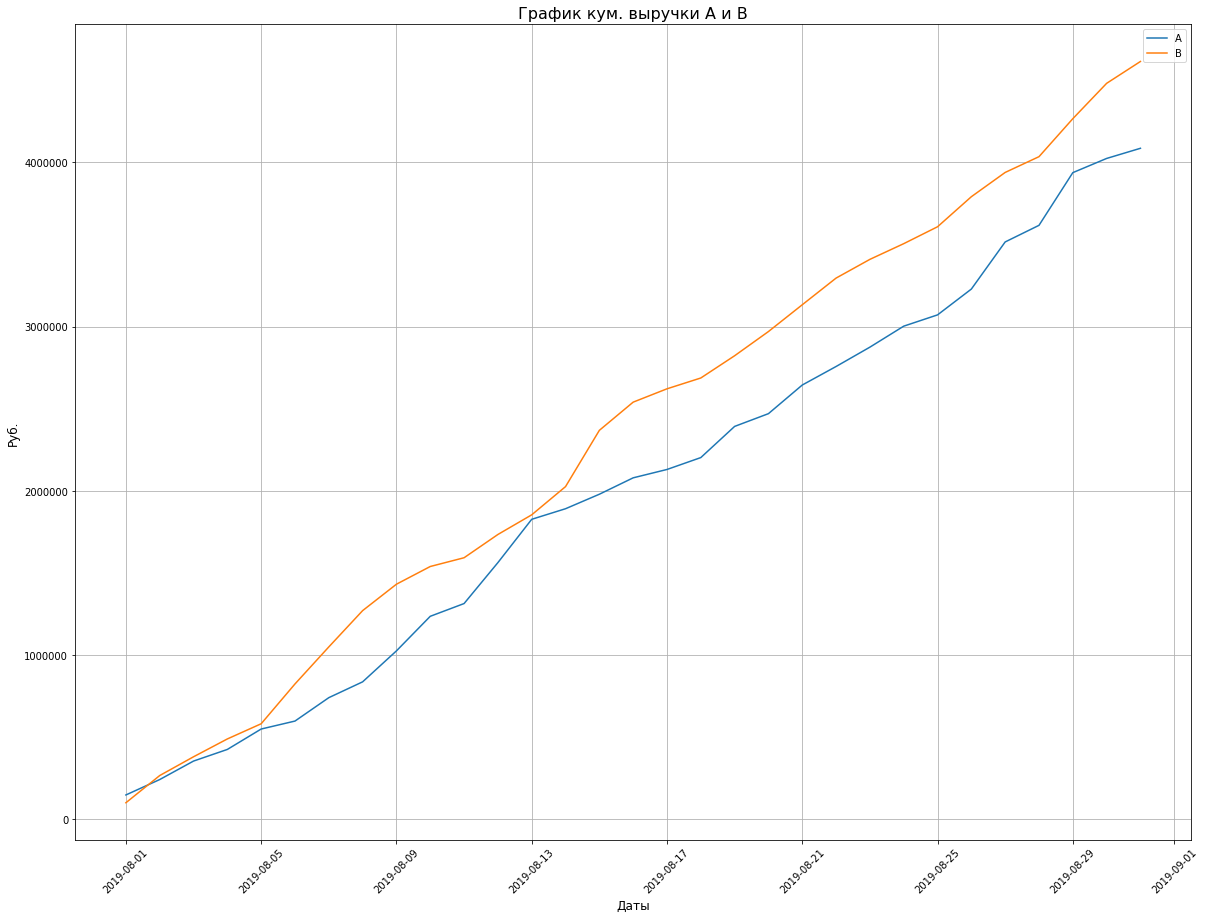

In [27]:
register_matplotlib_converters()
#А: cum revenue
plt.figure(figsize=(20,15))
plt.grid()
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'], label='A')
#В: сum revenue
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'], label='B')
plt.title("Cumulative revenue  А and В", fontsize=16)

plt.legend()
plt.xlabel('Dates', fontsize=12)
plt.ylabel('Currency', fontsize=12)
#plt.annotate('Outlier', xy=???)
plt.xticks(rotation=45)
plt.show()


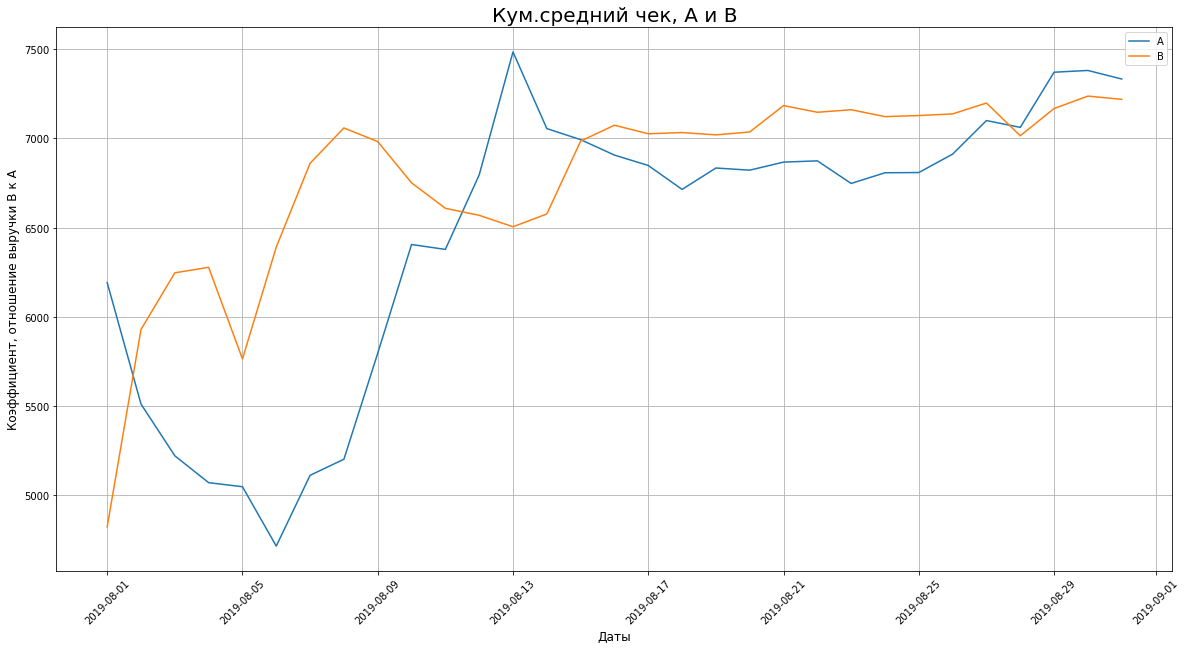

In [28]:
# Cumulative average invoice, А
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue']/cummulativeRevenueA['orders'], label='A')
# Cumulative average invoice, В
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue']/cummulativeRevenueB['orders'], label='B')
plt.legend()
plt.xlabel('Dates', fontsize=12)
plt.ylabel('Coefficient!proportion В to А', fontsize=12)
plt.title('Cumulative average invoice, А to В', fontsize=20)
plt.xticks(rotation=45)
plt.show()

### Preliminary result
Revenue: On August 13, both groups are almost equal in revenue. But then you can see that the graph of group B remains parallel to the graph of group A. Perhaps the case did not repeat itself.

Average check:
On August 13, group A has a buy that greatly distorts the average check. Group B has a drawdown this time.

### Ploting Cumulative average invoice

In [29]:
mergedCummulativeRevenue = cummulativeRevenueA.merge(cummulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

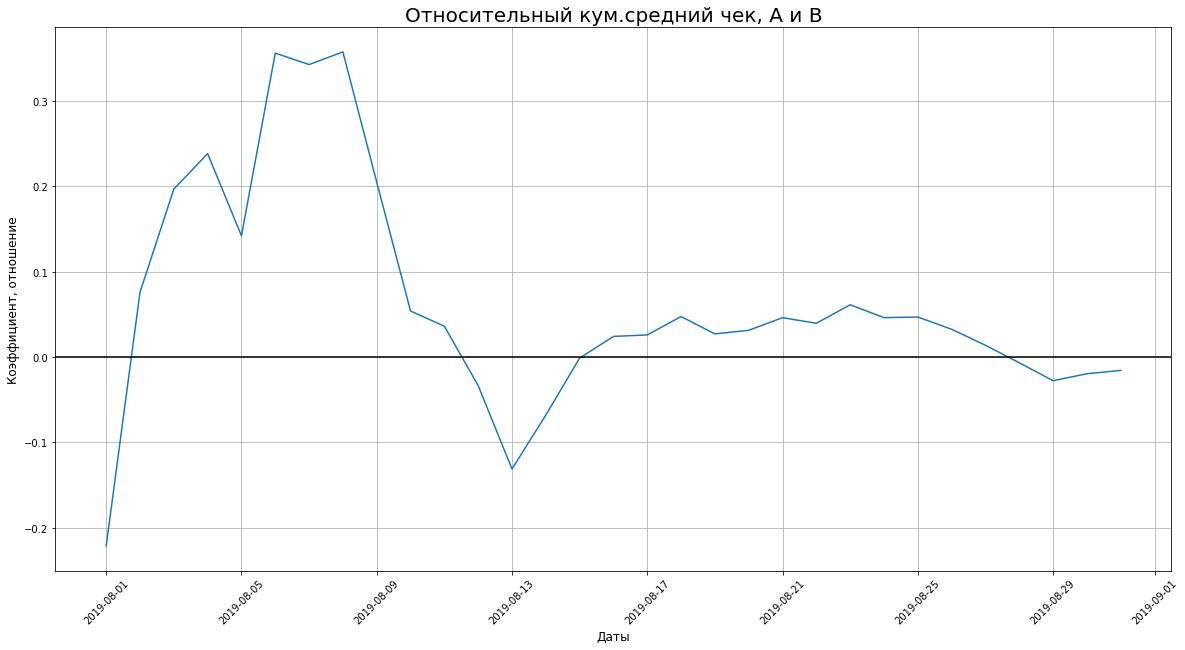

In [30]:
# Cumulative average invoice В to А
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(mergedCummulativeRevenue['date'], (mergedCummulativeRevenue['revenueB']/mergedCummulativeRevenue['ordersB'])/(mergedCummulativeRevenue['revenueA']/mergedCummulativeRevenue['ordersA'])-1)
plt.xlabel('Даты', fontsize=12)
plt.ylabel('Coefficient', fontsize=12)
plt.title('Relation Cum Avg Invoice, А and В', fontsize=20)
plt.axhline(y=0, color='black', linestyle='-')
plt.xticks(rotation=45)
plt.show()

**Preliminary conclusion**
The average check of group B according to uncleaned data falls in the second week of August: on August 13, according to the graph of cumulative revenue, group A reached the indicator of group B: the indicator of group A grew, and group B at that moment was in a slight decrease. Therefore, it is too early to draw hasty conclusions about the performance of group B.

The fact is that we are dealing with cumulative data, that is, those that accumulate. One outlier, one anomaly can distort the interpretation. If you study the graph of the ratio of the cumulative average invoice, it turns out that in August group B had an anomaly: the cumulative average invoice sagged a lot until the moment of a sharp increase, but this growth could be affected by an outlier.


Average check and revenue are important marketing indicators. But another important metric, often a KPI, is conversion. Let's study it.


### Ploting conversions

In [31]:
# Cumulative conversion
cummulativeData['conversion'] = cummulativeData['orders']/cummulativeData['visitors']


In [32]:
#A
cummulativeDataA = cummulativeData[cummulativeData['group']=='A']
#B
cummulativeDataB = cummulativeData[cummulativeData['group']=='B']


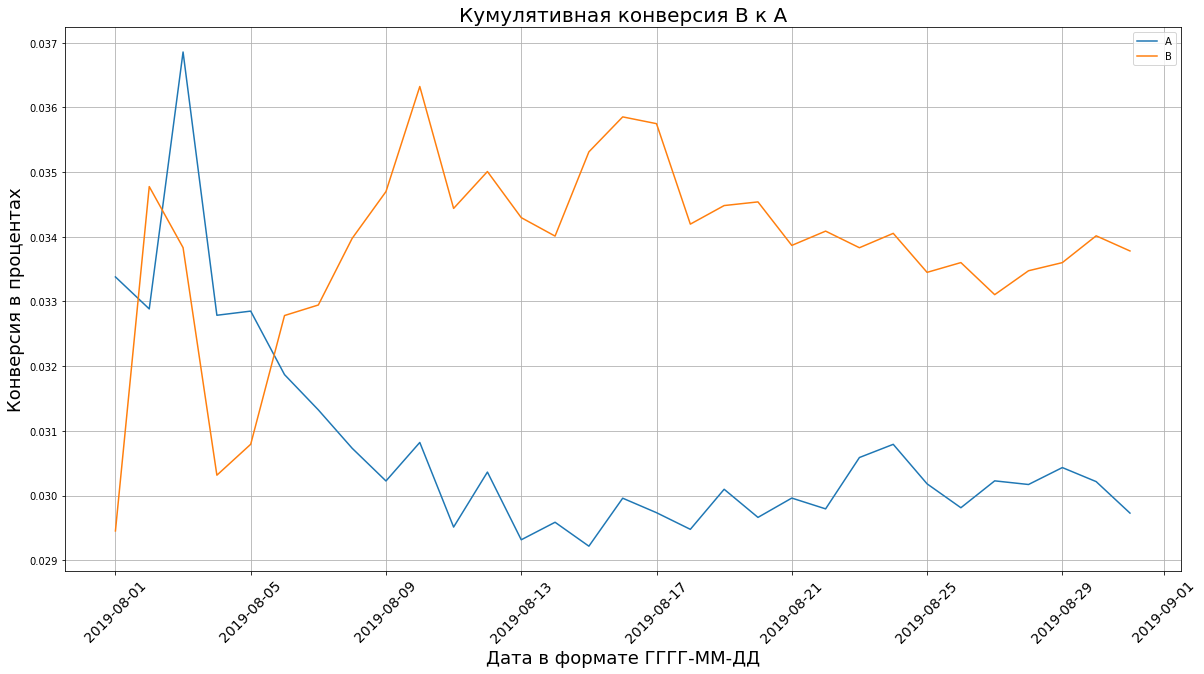

In [33]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 45, fontsize=14)
# Cumulative conversion group А
plt.plot(cummulativeDataA['date'], cummulativeDataA['conversion'], label='A')
# Cumulative conversion group В
plt.plot(cummulativeDataB['date'], cummulativeDataB['conversion'], label='B')
plt.title('Cumulative conversion В to А', fontsize=20)
plt.xlabel('Date YYYY-MM-DD', fontsize=18)
plt.ylabel('Conversion in %', fontsize=18)
plt.grid() 
plt.legend()
plt.show()

In [34]:
# Cumulative conversion A and B
mergedCummulativeConversions = cummulativeDataA[['date','conversion']].merge(cummulativeDataB[['date','conversion']], 
                                                                             left_on='date', right_on='date', how='left', 
                                                                             suffixes=['A', 'B'])


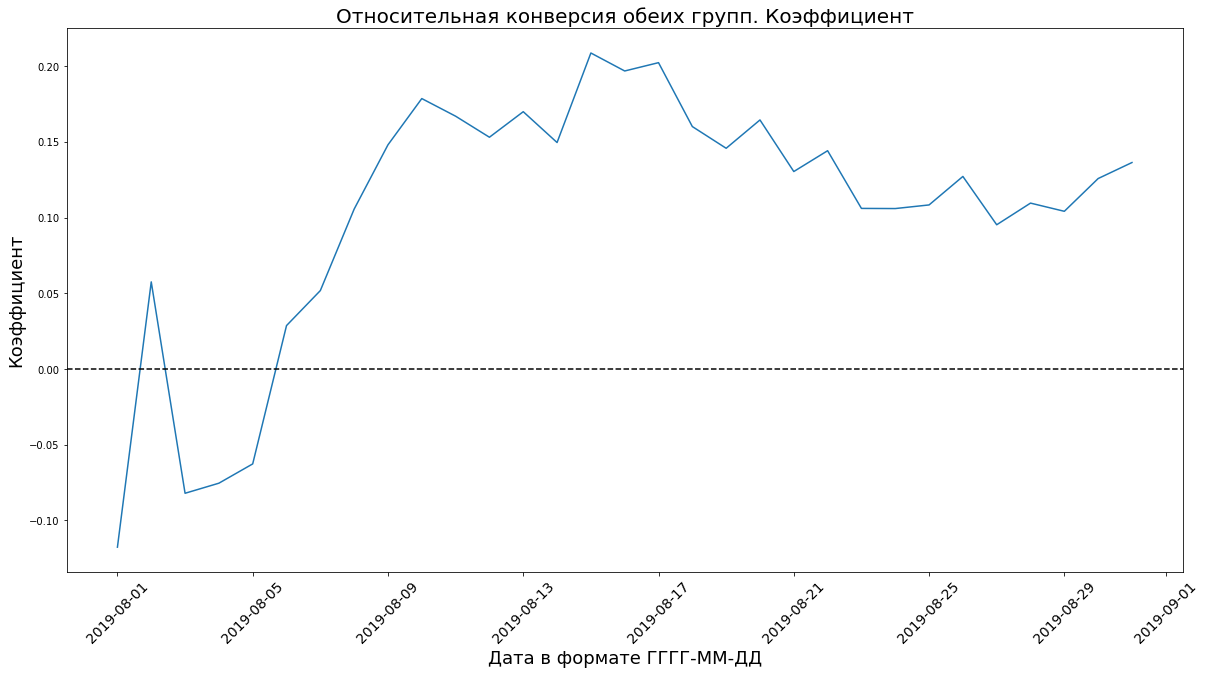

In [35]:
# Cumulative conversion B to A
plt.figure(figsize=(20,10))
plt.xticks(rotation = 45, fontsize=14)
plt.plot(mergedCummulativeConversions['date'], mergedCummulativeConversions['conversionB']/mergedCummulativeConversions['conversionA']-1)
plt.title('Relative conversion both groups', fontsize=20)
plt.xlabel('Date YYYY-MM-DD', fontsize=18)
plt.ylabel('Coefficient', fontsize=18)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()

### Preliminary output

We see that at the start, the conversion of group B is almost half a point higher. Then it sags and gives way to the first week of August. Then it goes forward from August 8, although the graph of the average check shows that until the second week the average check of group B relative to group A was in a drawdown. Already from the second - is growing. The trend continues

So far, we can only say that in group B,
an experiment, some kind of promotion that does not affect the main product, but affects the conversion - they start converting from the second week of August. This happens when, for example, there is a promotion for an accompanying product. The average check will be less, but the hype fuels the conversion, it is high.


The average invoice and revenue - here they are considered not by cohort, but cumulatively. The influence of anomalies is "smeared" over time. Let's find them and compare the performance of groups using statistical methods.

#### Tips

-- `from pandas.plotting import register_matplotlib_converters`

-- `register_matplotlib_converters()`

-- <code>plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) </code>
    

## Outliers and Benchmarks
<a class="anchor" id="outliers">

We found out that there is an anomaly in the data. Let's look. First, in the number of purchases per unique user.


In [36]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False). \
                                                                        agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['user_id','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)

,user_id,orders
590,2458001652,11
1022,4256040402,11
568,2378935119,9
486,2038680547,8
916,3803269165,5
896,3717692402,5
743,3062433592,5
55,237748145,5
299,1230306981,5
44,199603092,5


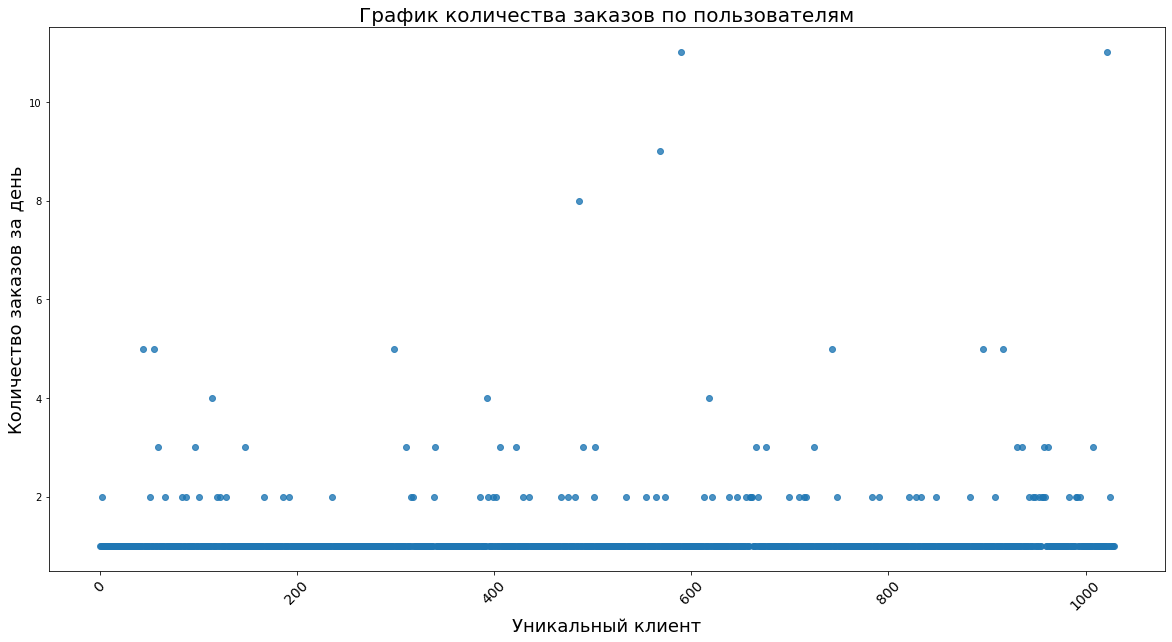

In [37]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(20,10))
plt.xticks(rotation = 45, fontsize=14)
plt.title('Qty of orders per client', fontsize=20)
plt.xlabel('Unique client', fontsize=18) 
plt.ylabel('Qty purchases daily', fontsize=18)
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.8) 
plt.show()


**Trends are clearly visible: a maximum of 1 purchase, then 2, then 4 - the rest of the outliers**

In [38]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))
bench_orders99 = np.percentile(ordersByUsers['orders'], [99])
ordersByUsersClean = ordersByUsers[ordersByUsers['orders'] < 4]
ordersByUsersClean

[2. 4.]


,user_id,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1025,4266935830,2
1026,4278982564,1
1027,4279090005,1
1028,4281247801,1


**Anomaly: > 4 purchases**


Ploting purchase costs WITHOUT an anomaly of 1,294,500 rubles. In general, it would be good to know the matter here: if this order occurred during the action and it could not have been under normal conditions, then it should be included.

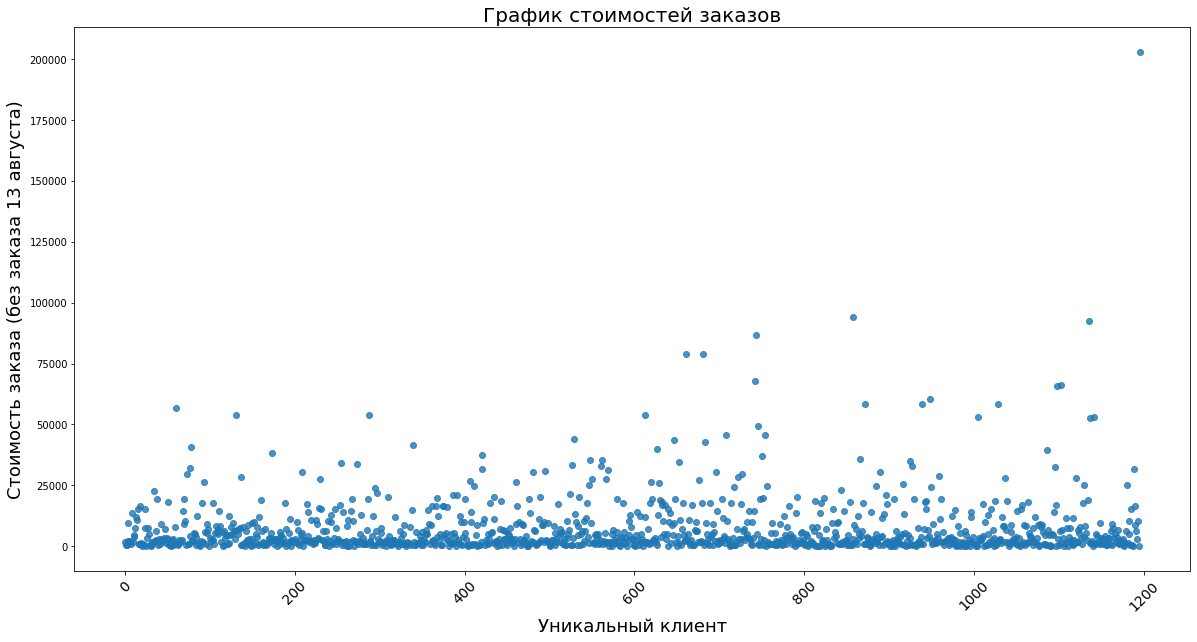

In [39]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(20,10))
plt.xticks(rotation = 45, fontsize=14)
plt.title('Purchase costs Plot', fontsize=20)
plt.xlabel('Unique client', fontsize=18) #новая строчка
plt.ylabel('Cost of purchase without outlier', fontsize=18) #новая строчка
plt.scatter(x_values, orders['revenue'], alpha=0.8)
plt.show()

In [40]:
extreme_outlier = orders['revenue'].max()
print(extreme_outlier, '(units) max cost')

202740 рублей — максимальная стоимость заказа


Calculating the 95th and 99th percentiles of order value. Select a border to detect anomalous orders.



In [41]:
print(np.percentile(orders['revenue'], [95, 99]))
overorder = np.percentile(orders['revenue'], [99]).astype(int)
print(overorder) #но мы это знаем из дескрайб))

[27696.25 58220.  ]
[58220]



**More than RUB 58,233 - an anomaly. The maximum purchase - 1,294,500 units - has already been removed from the data **


## Statistical significance of differences in conversion between groups on raw data



In [42]:
# Visits daily in А
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# Visits daily in В
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# Cumulative visits А
visitorsACummulative = cummulativeData[cummulativeData['group']=='A'][['date', 'visitors']]
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# Cumulative visits В
visitorsBCummulative = cummulativeData[cummulativeData['group']=='B'][['date', 'visitors']]
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

Tips

`print(df.columns.values)`

`lookup = {('revenue', 'A'): 'revenueA', ('revenue', 'B'): 'revenueB', ('transactionid', 'A'): 'transidA',  (название на level): 'transidB',}`

`df.columns = df.columns.to_flat_index()`

`df_4_normies = df.rename(columns=lookup)`

In [44]:
# Orders and revenue daily, А
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'}) #правка
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# Orders and revenue daily, В
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'}) #правка
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [45]:
# Merging
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(mergedCummulativeRevenue, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,revenueA,ordersA,revenueB,ordersB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,148579,24,101217,21,719,713,719,713
1,2019-08-02,20,93822,24,165531,242401,44,266748,45,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,354874,68,380996,61,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,425699,84,489567,78,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,549917,109,581995,101,756,707,3318,3280


In [46]:
# Qty of orders by unique client, А
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

# Qty of orders by unique client В
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

In [47]:
# Sampling А, В
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)



# Statistically significant - conversion and average checks based on data with outliers

<a class="anchor" id="statsign">

**We will consider as abnormal users those who made more than 4 orders or made an order more expensive than 58233 rubles. So we will remove 5% of users with the highest number of orders and from 1% to 5% of users with expensive orders.**

**HYPOTHESES**

0-hypothesis: No difference between samples (stop experiment)

Alternative hypothesis: There is a difference between the samples. One of the groups is the winner.

The difference between groups can also be displayed if it is statistically significant.


The Mann-Whitney test is complicated. One-sided test used if we definitely want to check that group A is greater than group B (or less). And a two-sided test is when group A can be more or less than group B. And if a statistical difference is found, then we just compare the metrics that we've checked in the test and see the difference in one or the second group.   
We compare the ranks of some values ​​with each other and this is not a conversion and not an average / median conversion in a group. Hypothesis must follow the example: the probability that an observation from population X exceeds an observation from population Y is 50%. And the reverse hypothesis is that such a probability is not equal to 50%.

Parametre `alternative = 'two-sided'.`

Based on article http://www.stat.yale.edu/Courses/1997-98/101/sigtest.htm#:~:text=An%20alternative%20hypothesis%20may%20be ,the%20direction%20does%20not%20matter.


**Data**

- Raw = with anomalies

- Filtered

**What need to do**

Conduct tests, compare the average invoice and conversion by groups, and then compare the tests based on raw and cleaned data.


**Why**

To find out:

    1) Is the hypothesis rolled out on group B productive? Is the average check better in the end?
    
    2) how outliers, anomalous purchases, influenced the course of the experiment.
    
    3) whether it is worth applying the product hypothesis for which group B was assembled or there is no difference, which means leaving group A as the current one and thinking about other hypotheses to increase conversion and average invoice/.

In [48]:
# Raw data difference in conversions
print("alpha =",0.05)
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
#относительную разницу можно и не считать — между выборками нет стат.значимой разницы.

alpha = 0.05
0.009


In [49]:
# Raw data difference in average invoice
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
# Relative margin: B to A. Disproportion in which direction?
print("Relative {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.382
Относительный показатель -0.016


In [50]:
# Clients with > 4 orders per day
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] >= 4]['userId'], ordersByUsersB[ordersByUsersB['orders'] >=4]['userId']], axis = 0)
# Clients who spent > 58000 units.
usersWithExpensiveOrders = orders[orders['revenue'] > 58000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

In [51]:
filtered = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

In [52]:
# Filtered data
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(filtered))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(filtered))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)


In [53]:
# Filtered data -- Difference in conversion 
print("{0:.5f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
#no significant difference.

0.01394



When assessing the statistical significance of the difference in conversions between groups B and A, there were no grounds to reject the hypothesis that the samples were equal: the barrier of 0.05 was not overcome.

In [54]:
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(filtered)))]['revenue'],
    orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(filtered)))]['revenue'], alternative = 'two-sided')[1]))


0.959


**Preliminary conclusion 1** When assessing the statistical significance of the difference in conversions between groups B and A, there are reasons to reject the hypothesis that the samples are equal: the difference is 0.959. We can also see what is the relative difference in the average check:

In [55]:
print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(filtered)))]['revenue'].mean()/
    orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(filtered)))]['revenue'].mean() - 1))

-0.014



**Preliminary conclusion 2** The relative difference is not in favor of B, if we remove abnormal purchases of more than 58,000 rubles. Group B converts better, but generates less revenue overall.

## Recommendations from the analyst and a possible course of action
<a class="anchor" id="concl">

I. Choice of product hypothesis.

The use of different methods revealed two solutions that, according to the Impact and Reach indicators, came out in the top 3. There are two that differ in the same parameters. Launching a promotion and adding a block about products cannot be considered unconditionally useful. The promotion will increase purchases, and information blocks will increase audience coverage. Two hypotheses were in the top of both ratings, two more require preparation:

**Add product recommendation blocks to your online store website to increase conversion and average order value'** is an inexpensive solution.

**Add two new traffic acquisition channels, which will allow you to attract 30% more users** - a potentially costly solution, before launching, you should optimize landing pages and email collection, as well as see how the buttons work, what is the user's path to purchase. Before applying this solution, we need to conduct at least usability testing.

→ To launch a promotion, we will first need to calculate the unit-economy and choose for whom and what services, goods, we can launch the promotion and in what amount. Consider seasonality, view historical data on the product.

**Add product recommendation blocks to the online store website to increase conversion and average order check** - this may be needed for retargeting.

II. Data analysis.
There are anomalous values ​​in the data. We removed one very large purchase of 1,294,500 rubles on August 13th. A benchmark of 58,000 rubles per order and 4 purchases per unique per day was chosen as a filter for the cost of the order.
We see that at the start, the conversion of group B is half a point higher. Then it sags and gives way to the first week of August. Then it goes forward from August 8 to 13, although the graph of the average check shows that since the second week the average check of group B relative to group A has been in drawdown. This happens when, for example, there is a promotion for an accompanying product. The average check will be less, but the hype fuels the conversion, it is high.

Since we relied on cumulative and relative graphs, we can only mark dates with extreme values. But anomalies in the cumulative data affect the results for a long time. In order to rely not on a visual graph, but to draw conclusions based on the data, we had to conduct an ab-test analysis.

    Both groups are independent. Threshold 0.05. We measure the statistical difference between groups in order to answer the question: can we consider that the samples are equal or there is a statistically significant difference in them. **Null hypothesis: samples are equal. Alternative: no, they are different, there is a statistically significant difference**. To evaluate the difference, we will measure the relative metric.

III. AV testing
We test hypotheses on two types of samples: 100% of users and 99% of users. The fact is that we cannot take into account the most extreme values. Even without obvious outliers, these extreme values ​​affect the results.

Conversions: Based on raw base data, group B does not convert much better than group A, based on the data. Although based on the graph, one could come to a false conclusion. According to the cleaned data, group B converts much better.
But: conversion to sales is better in and of itself. But the income is higher or not? The conversion may be higher, but for an inexpensive popular product.

According to the average invoice: according to raw data, B loses to A by 0.016, and according to cleared data, by 0.014. It still ends up making less money.

For business purposes, we recommend abandoning the experiment that was rolled out on group B and moving on to other growth experiments. And also set up retargeting and find a consultant to call "dear" customers, if the product being sold is of regular use.